In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False

In [143]:
data = pd.read_excel("deb.xlsx", index_col="date")
data

,count
date,
2019-08-16,68067.0
2019-08-18,64044.0
2019-08-18,62912.0
2019-08-19,78029.0
2019-08-20,78537.0
...,...
2020-05-27,NaN
2020-05-28,NaN
2020-05-29,NaN


In [129]:
# # df = data.set_index("date")
# # df
# df=data.set_index("date")
# df = pd.Series(df["count"].values,index=df.index)
# df

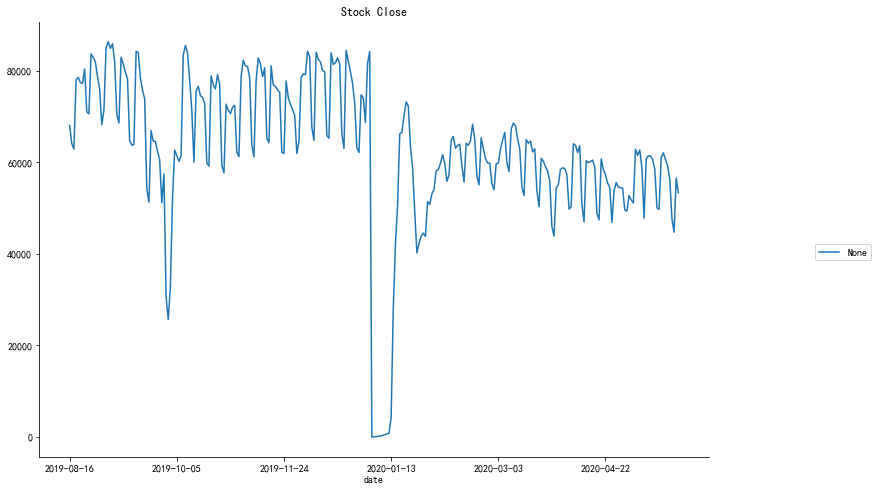

In [144]:
df.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Stock Close")
sns.despine()

In [131]:
def diff(timeseries):
    time_diff1=timeseries.diff(1).fillna(0) #1阶差分
    time_diff2=time_diff1.diff(1).fillna(0) #2阶差分

    time_adf=ADF(timeseries)
    time_diff1_adf=ADF(time_diff1)
    time_diff2_adf=ADF(time_diff2)

    return [time_diff1_adf,time_diff2_adf]

diff(df)

[(-6.1137988763070235,
  9.197422762283067e-08,
  13,
  271,
  {'1%': -3.4547128138328875,
   '5%': -2.8722649771800155,
   '10%': -2.5724850011573914},
  5570.969085977118),
 (-7.852424765483896,
  5.555375229660797e-12,
  16,
  268,
  {'1%': -3.454988209954765,
   '5%': -2.8723857312734613,
   '10%': -2.572549407997327},
  5600.730042993682)]

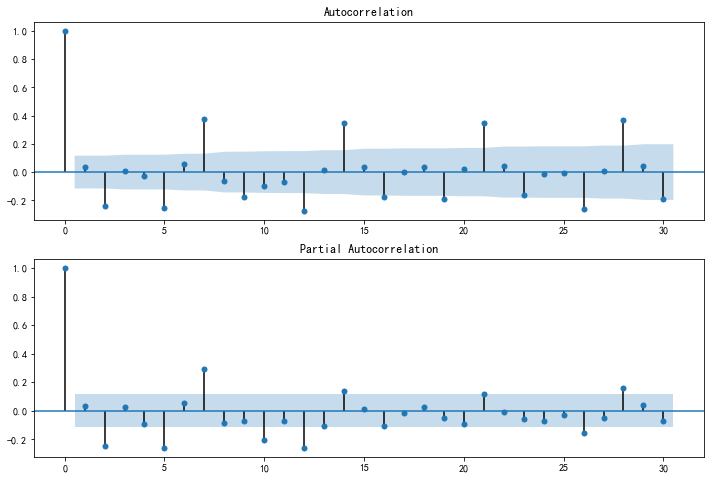

In [69]:
def autocorr(time_series,lags):
    fig=plt.figure(figsize=(12,8))
    ax1=fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(time_series,lags=lags,ax=ax1)

    ax2=fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(time_series,lags=lags,ax=ax2)

    plt.show()

time_diff1=df.diff(1).fillna(0) 
autocorr(time_diff1,30)

In [70]:
data_eva=sm.tsa.arma_order_select_ic(df,ic=["aic","bic"],trend="nc",max_ar=7,max_ma=7)
print("data_AIC",data_eva.aic_min_order)
print("data_BIC",data_eva.bic_min_order)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:670: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:672: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: Hes

data_AIC (5, 4)
data_BIC (5, 4)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [133]:
arma_54=sm.tsa.SARIMAX(df,order=(5,1,4)).fit()
print("arma_54",arma_54.aic,arma_54.bic,arma_54.hqic)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


arma_54 5913.625234375648 5950.11497675726 5928.254713933809


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


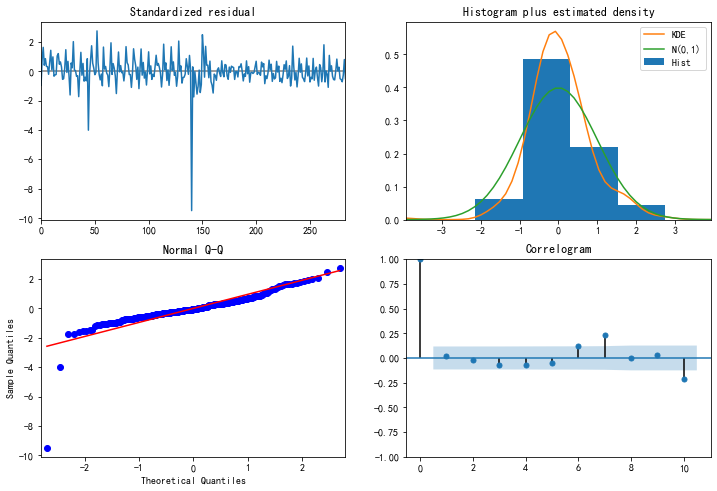

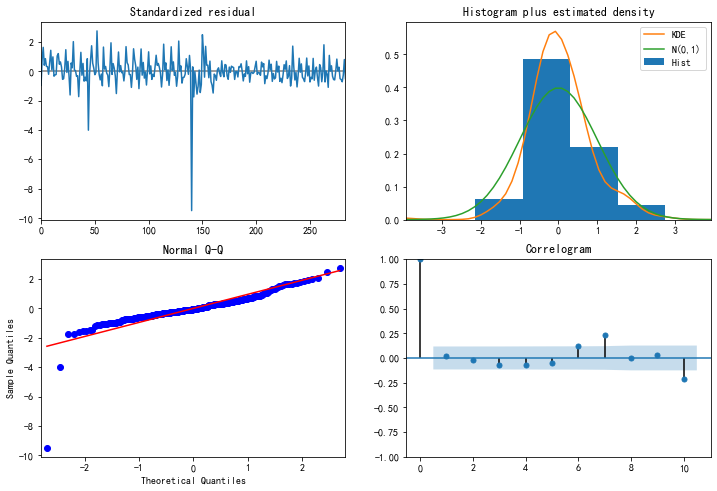

In [134]:
arma_54.plot_diagnostics(figsize=(12,8))

In [135]:
print(sm.stats.durbin_watson(arma_54.resid.values))

1.8006431252843091


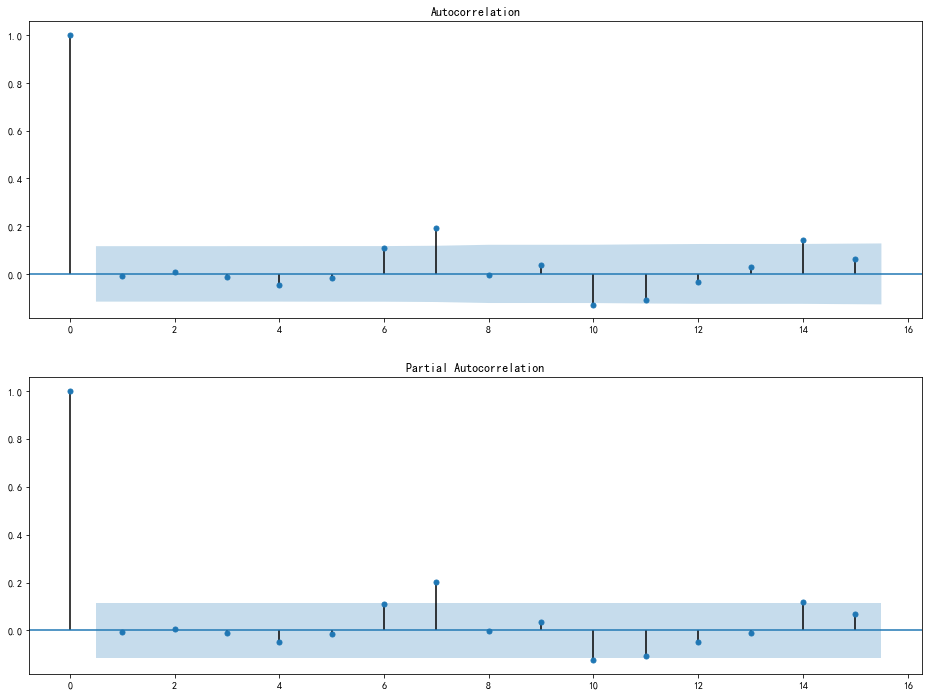

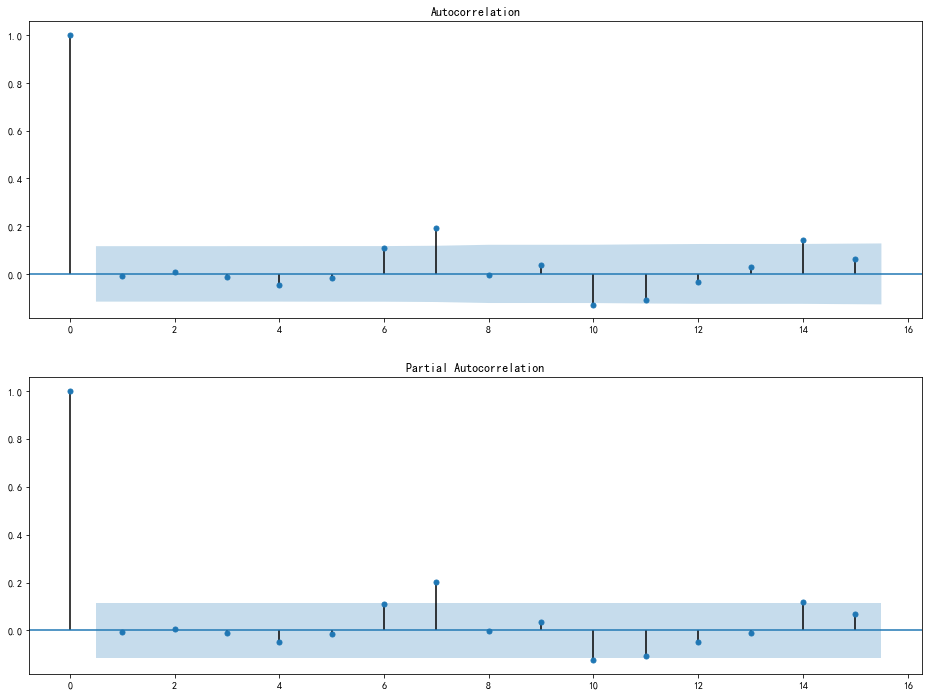

In [136]:
resid=arma_54.resid
fig=plt.figure(figsize=(16,12))
ax1=fig.add_subplot(211)
sm.graphics.tsa.plot_acf(resid,lags=15,ax=ax1)  #自相关系数

ax2=fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(resid,lags=15,ax=ax2)  #偏相关系数

In [137]:
acf,q,p=sm.tsa.acf(resid.values.squeeze(),nlags=20,qstat=True)
data=np.c_[range(1,21),acf[1:],q,p]
table=pd.DataFrame(data,columns=["lag","AC","Q","P-value"])
print(table.set_index("lag"))

            AC          Q   P-value
lag                                
1.0  -0.007712   0.017130  0.895868
2.0   0.008029   0.035762  0.982278
3.0  -0.012532   0.081313  0.993981
4.0  -0.047786   0.746005  0.945537
5.0  -0.015703   0.818037  0.975869
6.0   0.106687   4.154950  0.655716
7.0   0.191887  14.988585  0.036146
8.0  -0.005091  14.996238  0.059219
9.0   0.037355  15.409777  0.080278
10.0 -0.128121  20.292200  0.026607
11.0 -0.110148  23.914043  0.013101
12.0 -0.034122  24.262897  0.018729
13.0  0.028670  24.510073  0.026750
14.0  0.142843  30.668549  0.006167
15.0  0.064096  31.913133  0.006616
16.0  0.024074  32.089358  0.009735
17.0 -0.069781  33.575502  0.009521
18.0 -0.018623  33.681743  0.013785
19.0 -0.002445  33.683581  0.020021
20.0  0.045716  34.328680  0.023985


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [139]:
pre=arma_54.predict("2020-05-27","2020-05-30")

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [106]:
pre.tail(1)

date
2020-05-15    63251.392822
dtype: float64

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

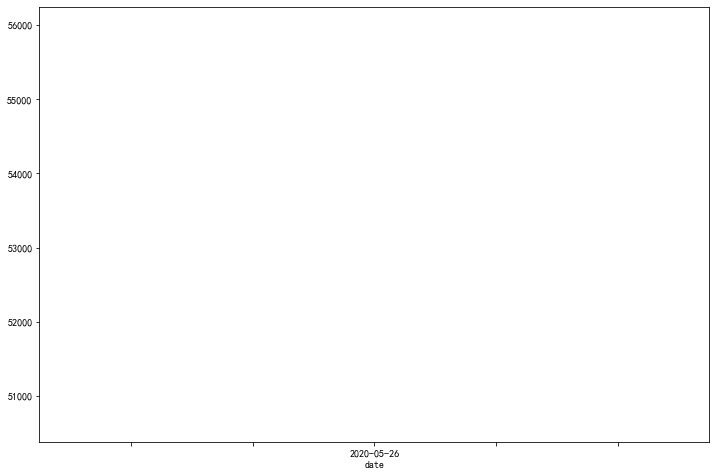

In [141]:
fig,ax=plt.subplots(figsize=(12,8))
ax=df.loc["2020-05-26":].plot(ax=ax)
fig=arma_54.predict("2020-05-27","2020-05-31",dynamic=True,ax=ax,plot_insample=False).plot(style="r-.")
plt.title("未来10天的销售额预测",fontsize=20)
plt.show()